In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
from snkrfinder.imports import *
from snkrfinder.core import *
from snkrfinder.data.munge import *
from snkrfinder.model.core import *
from snkrfinder.model.cvae import *

from fastai.test_utils import show_install, synth_learner, nvidia_smi, nvidia_mem

# train some architectures and save for testing inference.



## OVERVIEW: cvae module - convolutional variational auto encoder

preamble: This is a project initiated while an Insight Data Science fellow.  It grew out of my interest in making data driven tools in the fashion/retail space I had most recently been working.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some initial sneakers based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.

> NOTE: removing the nbdev tags ? actually pause for now...maybe a tutorial entry will be nice.


In [ ]:
#hide
show_install()



```text
=== Software === 
python        : 3.8.2
fastai        : 2.2.7
fastcore      : 1.3.19
fastprogress  : 0.2.7
torch         : 1.7.1
nvidia driver : 460.56
torch cuda    : 11.0 / is available
torch cudnn   : 8005 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : GeForce RTX 2070 SUPER

=== Environment === 
platform      : Linux-5.8.0-7642-generic-x86_64-with-glibc2.10
distro        : #47~1614007149~20.10~82fb226-Ubuntu SMP Tue Feb 23 02:59:01 UTC 
conda env     : fastai
python        : /home/ergonyc/anaconda3/envs/fastai/bin/python
sys.path      : /home/ergonyc/Projects/Project2.0/snkrfinder/nbs
/home/ergonyc/anaconda3/envs/fastai/lib/python38.zip
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/lib-dynload

/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg
/home/ergonyc/anaconda3/envs/fastai/lib/

In [ ]:
#hide
#nvidia_smi()


In [ ]:
#hide 
# fix our base directory
print(Path().cwd())
os.chdir(L_ROOT)
print(Path().cwd())

/home/ergonyc/Projects/Project2.0/snkrfinder
/home/ergonyc/Projects/Project2.0/snkrfinder


## PREP DATA Using  fastai V2: data pipelining
- Datablock API

Load the saved merged database, and set the seeds.  And doublecheck our data is where we expect.

In [ ]:

df = pd.read_pickle(f"data/{COMBINED_DF}.pkl")
np.random.seed(3333)
torch.manual_seed(3333)


In [ ]:
#TODO:  fix the data layout... the links and paths are screwy
image_path = L_ROOT/"data"
#image_path = D_ROOT/DBS['zappos']
batch_size = 64

L([image_path/d for d in df.path])

(#11771) [Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045616.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045632.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045650.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045650.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.396.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.4854.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/80

In [ ]:
df = prep_df_for_datablocks(df)

### AE:  deterministic AutoEncoder ( _non- variational_)

Although we give up the original utility we are going for --  creating new sneakers via the latent space -- having otherwise equivalent non-variational autoencoders for reference will be great. Furthermore, this latent space representation will be amenable to a MMD regularization later on.  This will be useful to avoid some of the limitiations of the KLD as a regularizer (overestimation of variance, and some degenerate convergences).
Its sort of _hack_-ey but keeping the tooling equivalent to the betaVAE will ultimatel give some advantages.

It is convenient to avoid the class wrappers to simplify the param splitting for freezing the pre-trained arcitecture.  
We could enumerate the class layers and return sequential, but simply making some functions to put the layers togeter is better.

#### Loss

These inherit from `Module`. (fastai's wrapper on `nn.Module`)

#### Metrics

These are called by the recorder callback and collect quantities to track training.  I made a simple meta class so I don't have to repreat the reset and mean value property for all the metrics.

##### helper for computing the KL Divergence as a function and a `Module`

The AnnealedLoss Callback basically injects a kl_weight parameter into the loss so we can start training without the full KLD regularization for the beta-VAE version.

The fastai `Learner` class does the training loop.  It took me a little digging into the code to figure out how Metrics are called since its not really stated anywhere in the documentation (_Note: create PR for fastai for extra documentation on `Metrics` logic_).  By default one of the key `Callbacks` is the `Recorder`.  It prints out the training summary at each epoch (via `ProgressCallBack`) and collects all the `Metrics`. Which by default only loss is a `train_met` and others are `valid_met`.
The `Recorder` resets (maps `reset()` to all mets) the metrics `before_train` and `before_valid`. The `Recorder` maps `accumulate()` to the metrics on `after_batch`.  Finally

AnnealedLossCallback will inject the latent mu and logvar and a kl_weight variable into our loss.  The `mu` and `logvar` will be used to compute the KLD. The kl_weight is a scheduled weighting for the KLD. You can see the schedule graph of the parameter. At the beginning it will be 0, thus the KLD part of the loss will get ignored. So during 10% of training, we will fit a normal auto-encoder. Then gradually for 30% of trainning, increase kl_weight to 1 and then remain there for the remaining training time so that the auto encoder now becomes full variational. The way this callback is done, the loss will receive this parameter, but not the model.

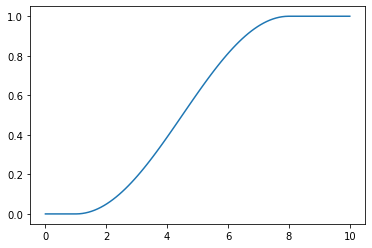

In [ ]:
# lets start with ~10 epochs of no KL regularizaiton, and ramp through the next 5
n_epochs = 10
f_init = combine_scheds([.1, .7, .2], [SchedNo(0,0),SchedCos(0,1), SchedNo(1,1)])
# f = combine_scheds([.8, .2], [SchedCos(0,0), SchedCos(0,.5)])
p = torch.linspace(0.,1.,100)
pp = torch.linspace(0.,1.*n_epochs,100)

plt.plot(pp,[f_init(o) for o in p])

WARNING: Avoid using early stopping because the AnnealedLossCallback will make the loss grow once the KL divergence weight kicks in. 




I want to note something here that was a little confusing to me: `params(model)` is a builtin fastai `PyTorch.core` function which returns all of the parameters of the modules.    i.e.
    
```python    
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]
```


The toplevel `fastai core` functions with simple names that _almost_ match class attributes was one of my biggest stumbling blocks in getting acquainted with the fastai v2 API.  (The other is the documentation which is _autogenerated_ by the fastdev frameworks from their development noteboooks.  More on that struggle and my tips if that is troblesome for you later (here).

> NOTE: that it is crucial that you don't freeze the batch norm layers.   The `bn_splitter` collects out all the batchnorm layers.  The simple splitting we do only freezes the `encoder` and leaves the latent layers (i.e. VAE or linear encoding bottlenedck) and the `decoder` in a parameter group with the batchnorm layers.



#### parameter `Splitters`

> WARNING:  there are two completely different `splitter`s in the FastAI API.  This `splitter` groups the model parameters into groups for `freezing` and for progressive learning rates. (The other one is splits data into train and validate.  I got imminiently confused when I first started with the API by this.

### other encoder and decoder types

> 1. MobileNet_v2 as the encoder, as a continuation of the original Sneaker Finder

> 2. simple bowtie convolutional encoder / decoder (Mimics the GOAT medium blog)
    - Architecture Hyperparameters:
        - Latent Size (research default 256, production default 32)
        - Filter Factor Size (research default 16, production default 32)
        - Latent Linear Hidden Layer Size (research default 2048, production default 1024)
        - The encoder architecture is as follows with research defaults from above:
            - Input 3x128x128 (conv2d block [conv2d, batchnorm2d, relu])
            - 16x64x64 (conv2d block [conv2d, batchnorm2d, relu])
            - 32x32x32 (conv2d block [conv2d, batchnorm2d, relu])
            - 64x16x16 (conv2d block [conv2d, batchnorm2d, relu])
            - 128x8x8 (conv2d block [conv2d, batchnorm2d, relu])
            - Flatten to 8192
            - 2048 (linear block [linear, batchnorm1d, relu])
            - Split the 2048 dimension into mu and log variance for the parameters of the latent distribution 
            - Latent mu size 256 (linear layer only with bias)
            - Latent logvar size 256 (linear layer only with bias)
        - In the middle here you can break out the BCE and KLD loss for the final loss term and use the standard reparam trick to sample from the latent distribution.
        - Decoder architecture an exact mirror 
            - Input 256
            - 2048 (linear block [linear, relu])
            - 8192 (linear block [linear, batchnorm1d, relu])
            - reshape (128x8x8)
            - 64x16x16 (conv2d transpose block [convtranspose2d, batchnorm2d, relu])
            - 32x32x32 (conv2d transpose block [convtranspose2d, batchnorm2d, relu])
            - 16x64x64 (conv2d transpose block [convtranspose2d, batchnorm2d, relu])
            - 3x128x128 (conv2d transpose [convtranspose2d, sigmoid]
        - For weight initialization I used a normal distribution centered at zero with 0.02 set for the stddev. Optimizer: Adam with default parameters, if I were to do it over again I'd spend more time here understanding the learning dynamics. The dataset was about ~10,000 with a 70/20/10 split, batch size 64, over 120 epochs, with a learning schedule to reduce when the loss started to plateau. No crazy image augmentation just resizing and standards flips. I used the ANN package Annoy to do the NN search for prod, normalizing the embeddings and using the cosine similarity, ANN factor was 128 for num_trees. 


> 3. MMD regularized VAE where the latents are drawn from a 

TODO: Ranger optimizer might really help .. test

We can also use the transfer learning VAE tooling we previously built.  We just need to create the convolutional encoder and pass it in... Note that we don't have a pre-trained option, so DON'T FREEZE!

Now just wrap that simple conv block architecture into a _builder_.   And a meta-wrapper to let us call the conv_encoder and pre-trained options with the same function.   (I'll also put the `get_pretrained_parts` function here now even though we won't use it till the next section, so that we can make the `get_encoder_parts` generic wrapper handle both properly.)

In [ ]:
latent_dim = 128

# equalize KLDiv wrt errors per pixel
alpha = 3*IMG_SIZE*IMG_SIZE/latent_dim
alpha /= 20  # 5% retularizer

batchmean = True 
useL1 = False
hidden_dim = None
# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),  ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

metrics = default_AE_metrics(alpha,batchmean,useL1)

block = get_ae_DataBlock(aug=True)
batch_size = 64
dls = block.dataloaders(df, batch_size=batch_size)

arch='vanilla'

vae = AE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = AELoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,


> NOTE: The `to_fp16()` callbacks work but increasing the batch size doesn't really speed things up.


(0.19054607152938843,
 0.12022644281387329,
 0.15538625717163085,
 0.15135611593723297)

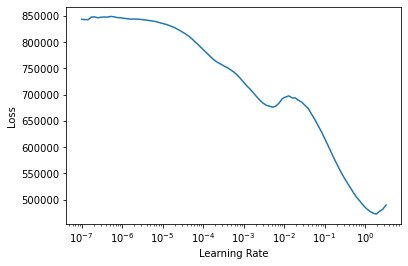

In [ ]:
lr1,lr2=learn.lr_find()

mlr, gmlr = .5*(lr1+lr2), torch.tensor([lr1,lr2]).log().mean().exp().tolist()
lr1,lr2,mlr,gmlr

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 100
learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)


# n_epoch = 10
# learn.fit_one_cycle(n_epoch,lr_max=lr1) #, lr_max= base_lr)

# learn.show_results()

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,l1_b_mean,weighted_kld,l1_latent_reg,mu_sd,logvar_sd,time
0,128097.382812,134643.968750,39930.207031,-0.002537,0.040510,-6.754639,52492.644531,11061.582031,157.764160,0.062668,0.851084,00:17
1,73394.687500,62053.113281,24703.388672,0.000699,0.041367,-7.137185,39147.574219,11797.055664,62.264362,0.052086,1.219310,00:17
2,44016.871094,37138.363281,17046.394531,-0.000633,0.028182,-8.103985,29868.207031,13646.053711,33.511909,0.034439,1.362805,00:17
3,36447.683594,26723.453125,12383.161133,-0.000669,0.021824,-8.450100,22675.261719,14307.659180,23.908924,0.026107,1.280745,00:17
4,26018.755859,25212.011719,11840.586914,-0.000326,0.018731,-8.512531,19481.261719,14426.326172,22.302107,0.022185,1.171001,00:17
5,18737.417969,16063.942383,10955.346680,-0.000264,0.007900,-10.935346,17432.310547,19076.392578,8.516870,0.009517,1.381128,00:16
6,14920.210938,12629.469727,9424.293945,-0.000146,0.004278,-12.010656,15719.267578,21140.630859,5.342623,0.005707,1.527276,00:17
7,11940.507812,11961.258789,9256.583984,-0.000045,0.003518,-12.485510,14622.348633,22052.294922,4.508440,0.004661,1.524205,00:17
8,9525.660156,9208.806641,8052.059082,-0.000059,0.000692,-15.689737,13443.873047,28204.300781,1.927498,0.001370,1.629675,00:17
9,8524.423828,8587.276367,7683.373047,-0.000030,0.000349,-17.240650,12673.233398,31182.044922,1.505545,0.001042,1.855216,00:17


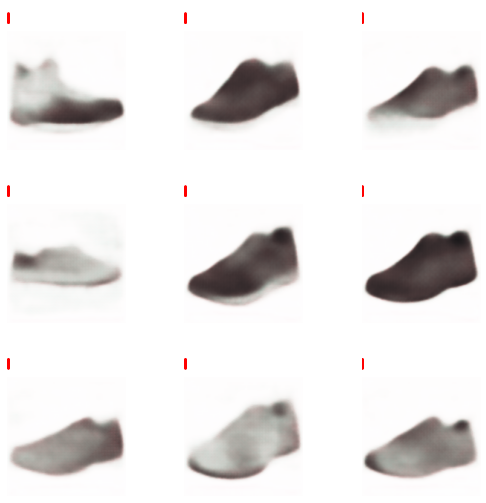

In [ ]:
learn.show_results()

In [ ]:
prefix = f"AE-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')


In [ ]:
# x,y,z = learn.dls.one_batch()
# x_hat,latents = learn.model.cuda()(x)

In [ ]:
# z, _ = latents.split(1,dim=2)

# dummy_var1 = (z.var(dim=1).unsqueeze(-1).expand(z.size()) )
# dummy_var2 = (z.var(dim=0).unsqueeze(0).expand(z.size()) )

# dummy_var1[:10,0],dummy_var2[:10,0]

### constructing VAE with Module Class Layers

For several of the decoder and "sampler" layers I might want to turn off the nonlinearity to give us more reasonable "gaussian" outputs to the Variational layer and the generated image which will is compared with the ImageNetStats batch-normalized image.



> IMPORTANT VAE TIP!!!   Make sure NOT to use batch normalization and non-linearity in the linear layers of the VAE.  The normalization will affect the representation and the KLD constraints.

### simple VAE class from VAE layer class components

once we have this we can do three things:

    1. develop proper VAE loss functions (including KL Divergence constraint on latent variables)
    2. create callbacks (and custom learner?) for training
    3. extend to a beta-variational framework with aims at creating "disentangled" latent dimensions
    

Putting it all together gives us our VAE!   Note that we'll pass in the "parts" of the encoder for ease of using pretrained (or not) architectures.   The model name will correspond to the architecture of the encoder via `name`.

Note that the `BVAE` can simply inherit from the `AE` class we defined above.  Really the only difference in the `__init__` function is that a `VAELayer` which performs the reparameterization trick replaces the `AElayer` as `self.bn` 

A nice wrapper for building the encoder parts will be handy.

Sweet, we've verified the arcitecture works, but we need to train it with a loss that constrains the variational layers with the KL Divergence.  Otherwise the simple MSE will diverge.  

### VAE Loss functions classes

We have acouple examples to follow:  

    1. TabularData Vae (fastai v2 patterning) (@EtienneT)

~~pure PyTorch Vae which is directly related to our image dataset (@AntixK)~~

In [ ]:
latent_dim = 128

# equalize KLDiv wrt errors per pixel
#  alpha = 3*IMG_SIZE*IMG_SIZE/latent_dim
alpha = 5
batchmean = True
useL1 = False
hidden_dim = None

# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
# start with KLweight on completely to enable sensible lr_find results
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]

metrics = default_VAE_metrics(alpha,batchmean,useL1)



In [ ]:
block = get_ae_DataBlock(aug=True)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

# arch,cut = resnet18(pretrained=True),-4
# enc_arch = list(arch.children())[:cut]
# enc_dim = 512
# enc_parts = enc_arch,enc_dim,'resnet18'

# replaced by:
enc_parts = get_pretrained_parts(arch=resnet18)

rnet_vae = BVAE(enc_parts, hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)
    
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)
learn = Learner(dls, rnet_vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,


In [ ]:
## fp16 isn't really speeding things up...
# learn = learn.to_fp16()

#learn.show_training_loop()


In [ ]:
# this freezes the resnet encoder (decoder = bottleneck + upsample)
learn.freeze()

(0.0002511886414140463,
 0.0003311311302240938,
 0.00029115988581907004,
 0.00028840304003097117)

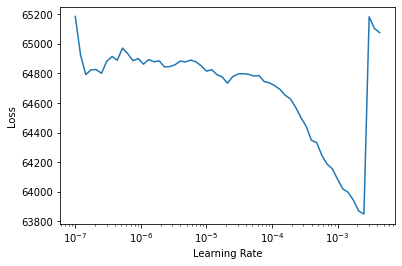

In [ ]:
# NOTE: lf_finder does NOT work correctly with our annealed kl_weight... 

lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#put in the annealied KL_weight...
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler

learn.add_cb(ParamScheduler({'kl_weight': default_KL_anneal_in()} ) )



epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,61706.023438,59401.890625,59200.527344,-0.183162,0.670351,-1.360018,1074.730103,0.182537,64435.050781,1.328313,0.744954,1.561802,00:22
1,58114.496094,54704.398438,54106.003906,-0.067606,0.709372,-1.241548,981.183960,0.604076,61621.859375,1.449838,0.450837,1.893286,00:22
2,55027.734375,52449.945312,52048.351562,-0.016363,0.778369,-0.767656,417.512909,0.947244,60466.074219,0.887459,0.376451,1.181295,00:22
3,53234.660156,51567.859375,51215.320312,-0.014475,0.771869,-0.710858,346.533447,1.000000,59968.601562,0.823350,0.310374,1.014969,00:22
4,52392.648438,51421.828125,51092.546875,-0.048797,0.782629,-0.654477,323.230713,1.000000,59896.394531,0.809924,0.289300,0.944704,00:22


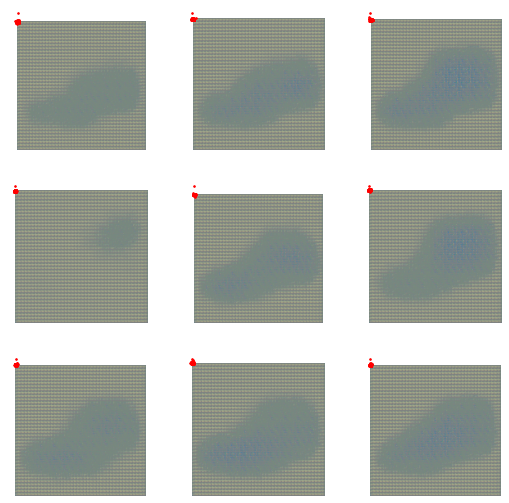

In [ ]:
#fit the backend of the VAE (n)
# the defaults are pretty good for now
n_epochs = 20

learn.fit_one_cycle(5,lr_max= lr1)#, lr_max= base_lr)
#learn.fit_flat_cos(n_epochs, lr=lr1, pct_start=0.5)
#learn.fit_flat_cos(n_epochs)
learn.show_results()


The vae with pretrained resnet encoder seems to train to a much better end-point if we keep the resnet frozen.  Hence the commented out `learn.unfreeze()` below.

In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

#learn.unfreeze()


(3.6307807022240014e-06,
 3.0199516913853586e-05,
 1.6915148808038794e-05,
 1.0471291716385167e-05)

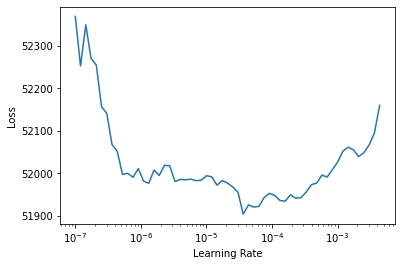

In [ ]:
learn.freeze()

lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#epochs = 5
base_lr = 1e-5# gmlr #/= 2
epochs = 20

#learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
#learn.fit_one_cycle(epochs, lr_max= 1e-3)
learn.fit_flat_cos(epochs,pct_start=.05)

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,73116.570312,56011.906250,41707.714844,-0.162279,0.150928,-43.849857,14298.664062,1.000000,53618.125000,1.220086,0.524610,36.704914,00:22
1,55711.816406,45964.726562,33920.769531,-0.043475,0.279428,-35.963737,12039.008789,1.000000,47239.265625,1.312494,0.757988,37.766373,00:22
2,44836.546875,37305.648438,27406.685547,-0.023731,0.321513,-29.381834,9895.095703,1.000000,41459.550781,1.460417,0.538946,35.474781,00:22
3,36200.839844,30034.455078,21493.714844,-0.048967,0.376191,-24.223383,8544.314453,1.000000,35556.191406,1.591922,0.687644,33.419842,00:22
4,29243.531250,26322.974609,17289.226562,-0.076567,0.462568,-20.003771,9098.589844,1.000000,30504.798828,1.651102,1.249426,31.537554,00:23
5,23948.765625,20693.746094,14159.992188,0.015880,0.476163,-17.972431,6532.034668,1.000000,27060.267578,1.679238,0.613610,30.386091,00:22
6,18914.341797,16118.884766,10100.545898,0.071780,0.485414,-15.699727,6016.059082,1.000000,21769.064453,1.614907,0.813107,28.720329,00:22
7,16302.161133,16133.471680,9065.597656,-0.032543,0.528036,-14.508196,7064.763672,1.000000,20103.945312,1.672818,0.956630,27.728195,00:23
8,14035.663086,13486.658203,8366.876953,-0.014977,0.549360,-13.761081,5118.403809,1.000000,18096.849609,1.596557,0.572698,27.181425,00:23
9,12555.615234,12438.543945,7636.028809,-0.001427,0.551520,-12.375941,4801.065430,1.000000,16884.033203,1.493703,0.722778,25.457499,00:22


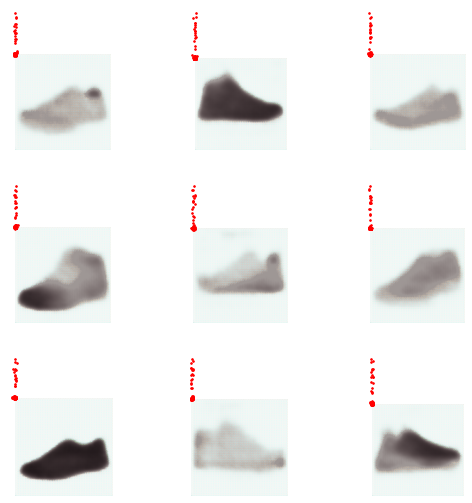

In [ ]:
learn.show_results()

In [ ]:
prefix = f"Vae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

### "_Vanilla_" convolutional beta-VAE

In [ ]:
latent_dim = 128

# equalize KLDiv wrt errors per pixel
#  alpha = 3*IMG_SIZE*IMG_SIZE/latent_dim
alpha = 5
batchmean = True
useL1 = False

# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight': default_KL_anneal_in() })]

metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='vanilla'
vae = BVAE(get_encoder_parts(arch), hidden_dim=None,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,






(0.13182567358016967,
 0.17378008365631104,
 0.15280287861824035,
 0.15135611593723297)

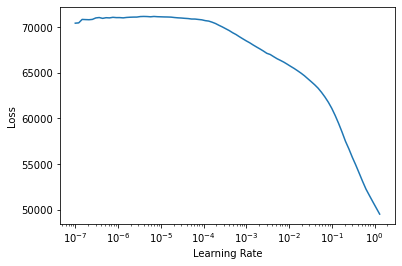

In [ ]:
lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,57399.710938,54946.996094,54929.402344,-0.165153,0.324608,-3.215317,4092.511963,0.003042,62103.660156,3.152873,0.228893,2.357134,00:17
1,51879.070312,47758.117188,47731.417969,-0.061124,0.344856,-2.523539,1779.545044,0.012332,57621.871094,1.957411,0.194889,1.265197,00:17
2,45386.617188,39933.128906,39885.570312,-0.019971,0.228078,-3.189618,1545.098267,0.027755,52250.078125,1.597886,0.104507,0.965323,00:17
3,38245.839844,32358.175781,32285.750000,0.007316,0.198953,-3.397292,1411.495117,0.049117,46108.632812,1.398528,0.077856,0.832803,00:17
4,31773.291016,26649.607422,26547.136719,0.007398,0.220232,-3.210758,1306.681519,0.076149,41807.441406,1.345289,0.088232,0.900020,00:17
5,26294.736328,22049.501953,21913.886719,-0.015827,0.214542,-3.225880,1222.396973,0.108512,37915.671875,1.239124,0.078933,0.783017,00:17
6,21699.671875,18236.214844,18065.015625,0.006644,0.228386,-3.092851,1153.687622,0.145797,34345.519531,1.203612,0.081635,0.765566,00:17
7,17847.849609,15316.773438,15123.155273,0.004208,0.257273,-2.837610,1015.710571,0.187537,31254.556641,1.121719,0.086920,0.723378,00:17
8,14701.538086,12635.338867,12391.008789,-0.013651,0.245611,-2.945722,1035.010498,0.233206,27929.199219,1.102923,0.089294,0.755788,00:18
9,12172.475586,10641.345703,10352.530273,-0.010108,0.255961,-2.870933,1013.395264,0.282230,25045.853516,1.103233,0.098628,0.761307,00:17


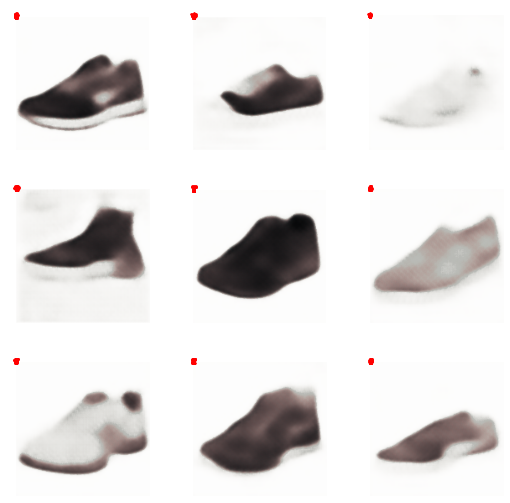

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 40
learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
# # warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
# n_epoch = 40
# learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.3)


# learn.show_results()

In [ ]:
# replace kl_weight scheduler... 
learn.remove_cb(learn.cbs[-1])

# add new scheduler
learn.add_cb(ParamScheduler({'kl_weight': SchedNo(1.,1.) }) )


In [ ]:
x=2

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 100
#learn.fit_flat_cos(n_epoch, lr=1e-4, div_final=1e5, pct_start=0.4)
learn.fit_flat_cos(n_epoch) 
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,3575.758301,3683.811279,3101.746826,0.023946,0.515511,-1.756194,581.610535,1.000000,7237.921387,0.842872,0.288098,1.441162,00:17
1,3442.707520,3683.277588,3096.911377,0.021387,0.522397,-1.781124,585.912415,1.000000,7176.047852,0.825728,0.305283,1.536284,00:17
2,3433.988037,3641.492676,3054.416504,-0.011133,0.513312,-1.801112,586.656189,1.000000,7096.828125,0.825289,0.293772,1.515173,00:17
3,3403.571533,3626.560791,3021.381592,0.014340,0.513209,-1.832552,604.736023,1.000000,6905.085449,0.837381,0.302017,1.569364,00:17
4,3390.826904,3625.273193,3048.279785,0.008304,0.522267,-1.787784,576.540222,1.000000,7141.823242,0.803791,0.305938,1.548868,00:17
5,3383.138672,3685.533936,3106.587646,0.017680,0.520357,-1.776290,578.446106,1.000000,7053.821289,0.818500,0.298193,1.524497,00:17
6,3362.476562,3586.350342,3008.823242,0.008792,0.524464,-1.767128,577.107422,1.000000,6952.917480,0.817344,0.303054,1.529652,00:18
7,3348.328613,3592.793701,3004.799072,0.016007,0.519604,-1.800429,587.577087,1.000000,6915.431152,0.820220,0.302051,1.562759,00:17
8,3340.515625,3638.916504,3065.810303,0.007080,0.526563,-1.763072,572.607056,1.000000,6980.000488,0.809834,0.303101,1.543575,00:17
9,3332.447021,3589.719971,2990.395996,0.005587,0.521241,-1.815432,598.889587,1.000000,6889.233887,0.829281,0.308591,1.598692,00:17


In [ ]:
prefix = f"Vae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

In [ ]:
lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 100
learn.fit_flat_cos(n_epoch, lr=5e-5,  pct_start=0.5)
#learn.fit_flat_cos(n_epoch) 
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"AE-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-2-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

In [ ]:
# vae = CVAE_vanilla()

# h = vae.enc.cuda()(x)
# z,mu,logvar = vae.cuda().reparam(h)
# x_hat = vae.dec.cuda()(z)
# x_hat2,latents = vae.cuda()(x)
# h.shape,z.shape,x_hat.shape, x_hat2.shape,latents.shape

## MMD-VAE  
> replace latent regularization term in loss_fn (KLD) with MMD

We'll make an `MMDVAE` class to keep things declarative, but its really just an `AE`.  i.e. a linear latent layer.

Additional background on MME from [https://github.com/Saswatm123/MMD-VAE]:

> Maximum Mean Discrepancy Variational Autoencoder, a member of the InfoVAE family that maximizes Mutual Information between the Isotropic Gaussian Prior (as the latent space) and the Data Distribution.\
Short explanation: The traditional VAE is known as the ELBO-VAE, named after the Evidence Lower Bound used in its objective. The ELBO suffers from two problems: overestimation of latent variance, and uninformative latent information.\
The latter is because one of the objective's terms is the KL-Divergence between the Gaussian parameterized by the encoder and the Standard Isotropic Gaussian. This dissuades usage of the latent code, so that the KL-Divergence term is allowed to fall even further. It is important to note that the KL-Divergence should never truly reach zero, as that means the encoder is not learning useful features and cannot find feature locality, and the decoder is just randomly sampling from Standard Gaussian noise.\
The overestimation of variance results from the KL-Divergence term not being strong enough to balance against the Reconstruction Error, and thus the Encoder prefers to learn a multimodal latent distribution with spread apart means, leading to low training error as it overfits, but low quality samples as well, as the sampling distribution is assumed to be a Standard Isotropic Gaussian. One effort to mitigate this effect is the Disentangled Variational Autoencoder, which simply raises the weight on the KL-Divergence term. However, this increases the problem stated in the paragraph above since it further penalizes using the latent code.\
For more detailed explanations, I used these resources to learn, in order of usefulness to me:\
    - https://arxiv.org/pdf/1706.02262.pdf \
    - http://ruishu.io/2018/03/14/vae/ \
    - http://approximateinference.org/accepted/HoffmanJohnson2016.pdf \
    - https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/ \
    - http://bjlkeng.github.io/posts/variational-bayes-and-the-mean-field-approximation/ \
    - https://ermongroup.github.io/cs228-notes/inference/variational/ \

#### Vanilla MMD VAE


In [ ]:
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
alpha = 20

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch='vanilla'
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    

In [ ]:
# mmd = MaxMeanDiscrepancy(batchmean=batchmean)
# x,y,z = learn.dls.one_batch()
# x_hat,latents = learn.model(x)

(0.33113112449646, 0.0831763744354248, 0.2071537494659424, 0.1659587025642395)

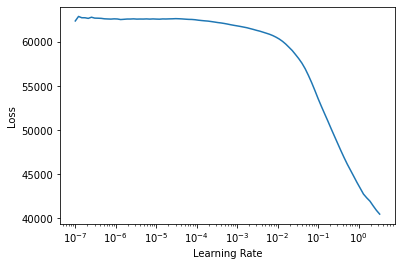

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr

# WARNING... the loss is way way way too high. to start with... so the numbers a bogus... 
# 10-3 is a good place to start

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 100
# learn.fit_flat_cos(n_epoch, lr=1e-2)
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.1)
# n_epoch = 10
learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,logvar,l1_b_mean,mu_sd,l1_latent_reg,weighted_kld,logvar_sd,time
0,60733.007812,59938.312500,59922.328125,10.132289,-0.002073,0.458049,-1.665590,64616.933594,0.687370,1236.550659,1764.858032,0.576036,00:17
1,59679.234375,58714.218750,58690.929688,17.179842,-0.022498,0.497475,-1.532395,63971.511719,0.831917,1548.480713,1946.046265,0.706977,00:17
2,58689.734375,57141.011719,57115.839844,19.067589,-0.043775,0.401922,-1.934005,63114.640625,0.797093,1557.016602,2262.438477,0.633678,00:17
3,57186.199219,55316.109375,55294.582031,15.886918,-0.051587,0.334264,-2.276578,61961.839844,0.707692,1439.692383,2443.822998,0.558843,00:17
4,55439.132812,53584.128906,53564.406250,14.332167,-0.026314,0.316326,-2.380292,60754.941406,0.673008,1368.563110,2492.041748,0.541350,00:17
5,53373.472656,51575.050781,51558.125000,11.704389,-0.042888,0.291572,-2.535823,59291.601562,0.606913,1252.181152,2562.535400,0.505314,00:17
6,50980.820312,49136.332031,49122.511719,9.637674,-0.044116,0.275874,-2.649644,57611.328125,0.553705,1146.596802,2616.819336,0.525480,00:17
7,48336.578125,46030.339844,46018.878906,9.047773,-0.048836,0.273378,-2.663074,55713.066406,0.538668,1114.231445,2610.769043,0.503601,00:17
8,45645.640625,43297.128906,43287.781250,8.836089,-0.044017,0.289757,-2.536232,53948.292969,0.543037,1112.280273,2464.342285,0.460135,00:17
9,42797.445312,40580.730469,40573.832031,8.791962,-0.041613,0.295322,-2.494899,52149.476562,0.545972,1113.194580,2418.588623,0.444961,00:17


In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

#### Higher alpha = 20

In [ ]:
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
alpha = 20

batchmean = True
useL1 = False

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 64
dls = block.dataloaders(df, batch_size=batch_size)


In [ ]:
arch='vanilla'
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr

# WARNING... the loss is way way way too high. to start with... so the numbers a bogus... 
# 10-3 is a good place to start

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 100
learn.fit_flat_cos(n_epoch)#, lr=lr1)
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.1)
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### ResNet Encoder MMDVAE

In [ ]:
# # arch = resnet50(pretrained=True)
# # cut = model_meta[resnet50]['cut']
# # enc_arch = list(arch.children())[:cut]
# # nn.Sequential(*enc_arch).cuda()(x).shape
# arch=resnet18
# cut = model_meta[arch]['cut']
# arch = arch(pretrained=True)
# enc_arch = list(arch.children())[:cut]
# enc_dim = 512
# vae = MMDVAE(enc_arch,enc_dim=enc_dim, hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)


####  L2 error func

In [ ]:

    
    
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
alpha = 10

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch=resnet18
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    
learn.freeze()


In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
learn.unfreeze()
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'TMP'}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
#learn.export(f'{filename}.pkl')

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 5
learn.unfreeze()
learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e6, pct_start=0.7)
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e5, pct_start=0.5)
learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"unfrozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

In [ ]:

    
    
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
alpha = 20

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch=resnet18
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    
learn.freeze()


In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
#learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e5, pct_start=0.5)
learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

In [ ]:
learn.unfreeze()
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#n_epoch = 100
#learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e6, pct_start=0.05)
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e5, pct_start=0.5)
learn.fit_one_cycle(5) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"unfrozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

### resnet arch no freeze

#### vanilla MMD VAE

In [ ]:
# latent_dim = 128

# # cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
# #                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
# #                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

# alpha = 8
# batchmean = False

# metrics = [MMDMetric(batchmean=batchmean,alpha=alpha), 
#            L1MeanMetric(), 
#            MuMetric(), 
#            StdMetric(),
#            LogvarMetric(),
#            L2MeanMetric(),
#            WeightedKLDMetric(batchmean=batchmean,alpha=alpha),
#            KLWeightMetric(), 
#            MuSDMetric(), 
#            LogvarSDMetric(),
#            RawKLDMetric(batchmean=batchmean)
#           ]


# batch_size = 64
# dls = block.dataloaders(df, batch_size=batch_size)


In [ ]:

    
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
alpha = 10

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch=resnet18
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    
learn.unfreeze()


In [ ]:
n_epoch = 200
learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.1)

learn.show_results()

In [ ]:
prefix = f"MMDVae-nofreeze{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

In [ ]:
    
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
alpha = 20

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch=resnet18
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    
learn.unfreeze()


In [ ]:
n_epoch = 200
learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.1)

learn.show_results()

In [ ]:
prefix = f"MMDVae-nofreeze{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

## vanilla-resnet MMD-VAE
##### ResBlocks replacing Conv2d in encoder AND decoder.
'Vanilla' encoder made with resnet blocks instead of conv blocks and `Mish` activation

### 128 latents, alpha=10

In [ ]:
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE,isVAE=False)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    
    

    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'TMP'}-latent{latent_dim}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### 128 latents, alpha=20

In [ ]:
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 20
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'TMP'}-latent{latent_dim}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### 64 latents, alpha=10

In [ ]:
latent_dim = 64

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'TMP'}-latent{latent_dim}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

### 64 latents, alpha = 20

In [ ]:
latent_dim = 64

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'TMP'}-latent{latent_dim}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'exports/{filename}.pkl')

Path('models/frozen-MMDVae-TMP-latent64-resblock-alpha10_2021-03-24_14.17.51.pth')

## vanilla-resnet beta-VAE

In [ ]:
class ResBlockBVAE(BVAE):
    """
    simple VAE with a _probably_ pretrained encoder 
    """

    def __init__(self,enc_parts,hidden_dim=None, latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
       
        """
        inputs:  
            enc_arch (pre-cut / pretrained)
            enc_dim
            latent_dim
            hidden_dim
            im_size,out_range
        """
        enc_arch,enc_feats,name = enc_parts

        # encoder
        #  arch,cut = xresnet18(pretrained=True),-4
        #  enc_arch = list(arch.children())[:cut]
        
        BASE = im_size//2**5
        enc_dim = enc_feats * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800

        self.encoder = build_AE_encoder(enc_arch,enc_dim=enc_dim, hidden_dim=hidden_dim, im_size=im_size)

        in_dim = enc_dim if hidden_dim is None else hidden_dim

        # VAE Bottleneck
        self.bn = VAELayer(in_dim,latent_dim)     

        #decoder
        self.decoder = build_ResBlockAE_decoder(hidden_dim=hidden_dim, latent_dim=latent_dim, im_size=im_size,out_range=out_range)

        store_attr('name,enc_dim, in_dim,hidden_dim,latent_dim,im_size,out_range') # do i need all these?




#  THESE ARE INHERITED..
#     def decode(self, z):    
#         z = self.decoder(z)
#         return z
    
#     def reparam(self, h):
#         return self.bn(h)

#     def encode(self, x):
#         h = self.encoder(x)
#         z, mu, logvar = self.reparam(h)
#         return z, mu, logvar

#     def forward(self, x):
#         z, mu, logvar = self.encode(x)
#         x_hat = self.decode(z)
#         latents = torch.stack([mu,logvar],dim=-1)
#         return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]
        
        
        

### 128 latents, alpha=5

In [ ]:
latent_dim = 128
alpha = 5 # doubled because latent is half?
batchmean = True
useL1 = False

# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]


metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resnblock'
vae = ResBlockBVAE(get_resblockencoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,



(1.584893179824576e-05,
 0.0020892962347716093,
 0.0010525725832849276,
 0.00018197020108345896)

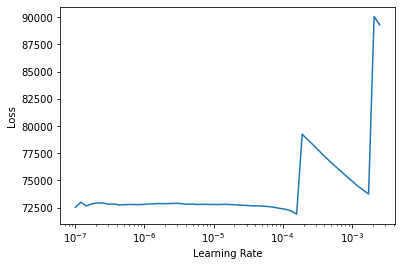

In [ ]:
# NOTE: lf_finder does NOT work correctly with our annealed kl_weight... 

lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#put in the annealied KL_weight...
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight': default_KL_anneal_in()} ) )

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,65233.792969,58382.683594,58351.417969,-0.086617,0.417598,-1.865430,524.921326,0.047932,64159.679688,0.731085,0.180286,0.606635,00:24
1,57977.343750,54620.535156,54469.769531,-0.070711,0.265423,-2.859225,777.994385,0.185387,62161.152344,0.683980,0.125794,0.837860,00:24
2,45760.007812,30962.054688,30497.566406,-0.041507,0.129733,-4.503492,1191.093140,0.385156,45622.253906,0.433279,0.090031,1.210061,00:23
3,38679.675781,33304.886719,32622.548828,-0.036134,0.135739,-4.323694,1114.364258,0.607671,46044.226562,0.360790,0.081173,1.091806,00:24
4,35558.074219,31729.720703,30949.904297,-0.031653,0.166531,-3.824231,957.622986,0.808860,45049.511719,0.362177,0.082095,0.966679,00:24
5,33872.394531,29816.603516,28993.126953,-0.034253,0.193060,-3.511334,862.640442,0.948876,43887.097656,0.369434,0.090878,0.950955,00:24
6,32833.234375,30804.404297,30026.019531,-0.035360,0.223429,-3.207990,773.189270,0.999986,44394.308594,0.382544,0.098618,0.945359,00:24
7,31953.218750,30045.203125,29306.019531,-0.036854,0.241424,-3.067944,734.272400,1.000000,44039.339844,0.392916,0.108256,0.992181,00:24
8,31427.435547,30594.882812,29865.537109,-0.036771,0.248724,-3.025772,724.120850,1.000000,44445.597656,0.400045,0.114237,1.036586,00:23
9,31202.517578,31042.628906,30323.289062,-0.036988,0.252945,-2.992517,714.604858,1.000000,44750.980469,0.401228,0.116041,1.039447,00:24


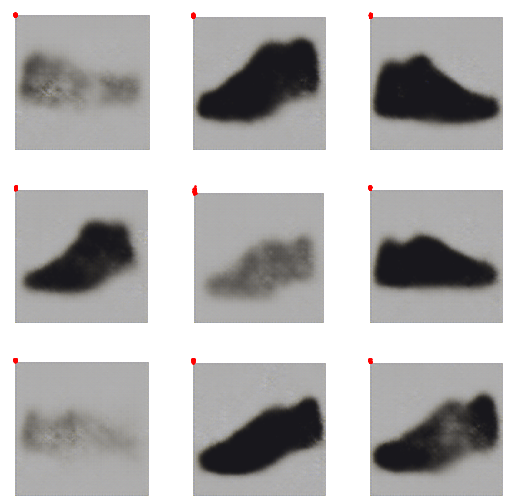

In [ ]:
#fit the backend of the VAE (n)
# the defaults are pretty good for now
n_epochs = 10

#learn.fit_one_cycle(freeze_epochs1,lr_max= lr1)#, lr_max= base_lr)
#learn.fit_flat_cos(n_epochs, lr=lr1, pct_start=0.5)
learn.fit_flat_cos(n_epochs, lr=1e-4,pct_start=0.5)

learn.show_results()


This initial "burning in" of the KLD regularization is very unstable...

In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

#learn.unfreeze()


(7.585775892948732e-06,
 2.2908675418875646e-06,
 4.9383217174181485e-06,
 4.1686930671858136e-06)

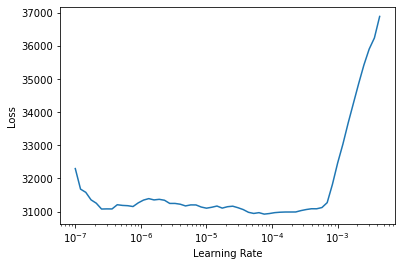

In [ ]:

lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,30675.833984,27812.943359,27134.195312,-0.039961,0.276390,-2.816809,673.386841,1.000000,42227.128906,0.438679,0.126263,1.065591,00:24
1,29938.101562,26859.117188,26255.351562,-0.039508,0.312127,-2.563431,598.351440,1.000000,41634.433594,0.435044,0.131939,1.053764,00:24
2,29060.966797,25753.396484,25177.488281,-0.040334,0.341044,-2.415996,570.952209,1.000000,40648.421875,0.476074,0.150751,1.134789,00:23
3,28079.830078,25241.945312,24715.017578,-0.044556,0.376892,-2.227615,523.777222,1.000000,40235.453125,0.487095,0.164622,1.176777,00:24
4,27119.945312,23880.552734,23393.728516,-0.045672,0.420166,-2.015576,481.767395,1.000000,39197.824219,0.525982,0.181364,1.202380,00:24
5,26193.960938,22554.802734,22099.820312,-0.042545,0.445449,-1.907331,450.723999,1.000000,38150.582031,0.512208,0.194543,1.220606,00:23
6,25237.720703,21849.195312,21412.589844,-0.045725,0.471781,-1.815367,433.203339,1.000000,37528.730469,0.520209,0.205637,1.289233,00:23
7,24265.757812,21210.136719,20798.203125,-0.042825,0.499014,-1.701803,407.708527,1.000000,36924.511719,0.523806,0.214993,1.292840,00:24
8,23297.937500,20385.326172,19993.966797,-0.037406,0.527553,-1.606700,388.013855,1.000000,36164.285156,0.523550,0.226418,1.339654,00:24
9,22327.806641,19567.037109,19184.189453,-0.036378,0.540535,-1.553920,378.611237,1.000000,35282.820312,0.531846,0.228771,1.337777,00:23


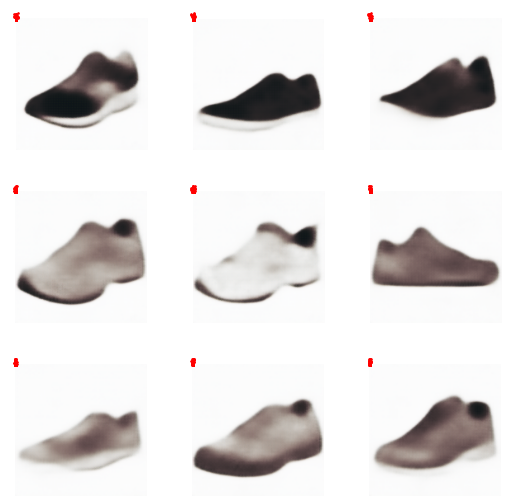

In [ ]:
#epochs = 5
base_lr = 1e-5# gmlr #/= 2
epochs = 200

#learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
#learn.fit_one_cycle(epochs, lr_max= 1e-3)
#learn.fit_flat_cos(epochs,lr=lr1,pct_start=.05)
learn.fit_flat_cos(epochs,lr=1e-4)
learn.show_results()

In [ ]:
prefix = f"BVae-{'TMP'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

In [ ]:
x = 1

### 128 latents, alpha=10

In [ ]:
latent_dim = 128
alpha = 10 # doubled because latent is half?
batchmean = True
useL1 = False



# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]


metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resnblock'
vae = ResBlockBVAE(get_resblockencoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,



(0.0001737800776027143,
 0.0006918309954926372,
 0.00043280553654767573,
 0.00034673692425712943)

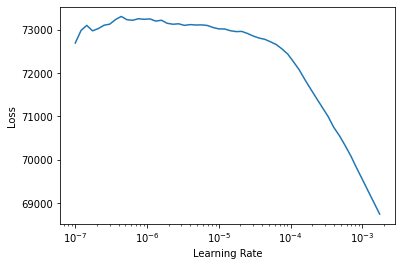

In [ ]:
# NOTE: lf_finder does NOT work correctly with our annealed kl_weight... 

lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#put in the annealied KL_weight...
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight': default_KL_anneal_in()} ) )

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,61659.449219,58386.406250,58341.000000,-0.019857,0.455781,-1.671904,832.637207,0.047932,64135.601562,0.625861,0.147662,0.573776,00:23
1,58109.093750,57061.496094,56769.277344,-0.013797,0.242717,-3.017259,1555.233887,0.185387,62878.757812,0.579620,0.101266,0.776061,00:24
2,47969.746094,33437.644531,32448.412109,-0.017085,0.098823,-4.857799,2547.863525,0.385156,46636.515625,0.331879,0.047261,0.872048,00:24
3,39651.195312,34911.757812,33742.105469,-0.007367,0.155824,-3.861760,1919.789795,0.607671,46535.753906,0.331306,0.057842,0.730127,00:24
4,36007.402344,32237.333984,31084.037109,-0.005098,0.237819,-3.006485,1420.887817,0.808860,44951.976562,0.386884,0.082873,0.740189,00:24
5,34110.375000,31359.648438,30322.738281,-0.008991,0.323596,-2.401854,1088.331787,0.948876,44440.128906,0.425158,0.112647,0.797205,00:24
6,32776.292969,30363.746094,29454.599609,-0.018964,0.398912,-2.013221,904.390381,0.999986,43905.945312,0.468204,0.144234,0.905123,00:24
7,31832.470703,30461.925781,29645.638672,-0.018195,0.451844,-1.793879,812.476440,1.000000,44021.691406,0.491595,0.170636,0.998887,00:24
8,31199.527344,30086.998047,29327.585938,-0.020831,0.487923,-1.655690,755.480530,1.000000,43909.707031,0.501118,0.186616,1.049374,00:24
9,30913.292969,30660.708984,29895.957031,-0.022691,0.490275,-1.652005,760.593445,1.000000,44297.753906,0.509429,0.188992,1.066286,00:24


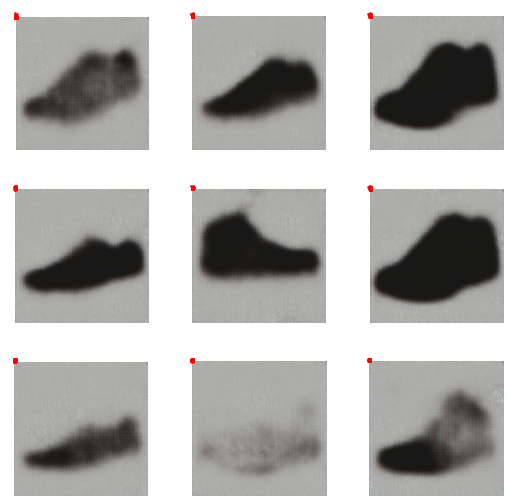

In [ ]:
#fit the backend of the VAE (n)
# the defaults are pretty good for now
n_epochs = 10

#learn.fit_one_cycle(freeze_epochs1,lr_max= lr1)#, lr_max= base_lr)
#learn.fit_flat_cos(n_epochs, lr=lr1, pct_start=0.5)
learn.fit_flat_cos(n_epochs, lr=1e-4,pct_start=0.5)

learn.show_results()


This initial "burning in" of the KLD regularization is very unstable...

In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

#learn.unfreeze()


(6.309573450380412e-08,
 5.754399353463668e-06,
 2.9087475439837364e-06,
 6.025593393133022e-07)

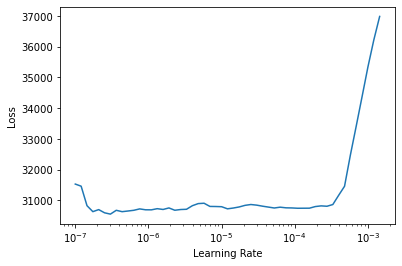

In [ ]:

lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,30546.468750,26397.720703,25685.345703,-0.021313,0.509091,-1.551260,708.255127,1.000000,41263.378906,0.512466,0.180644,1.013128,00:23
1,29692.494141,26511.996094,25870.472656,-0.012507,0.558817,-1.373599,637.351562,1.000000,41294.757812,0.519448,0.198468,1.046069,00:23
2,28793.232422,25462.740234,24876.683594,-0.015658,0.597393,-1.240524,582.221375,1.000000,40392.195312,0.518251,0.206879,1.061381,00:24
3,27968.285156,25022.761719,24435.962891,-0.018000,0.611624,-1.209632,582.810913,1.000000,40069.828125,0.529406,0.213530,1.120132,00:24
4,27108.156250,24701.246094,24172.044922,-0.010922,0.650966,-1.080204,525.096375,1.000000,39861.804688,0.516095,0.222308,1.114292,00:24
5,26274.621094,23537.603516,22994.050781,-0.024665,0.653342,-1.082168,539.942261,1.000000,38980.031250,0.532508,0.223346,1.149300,00:24
6,25370.417969,22816.164062,22316.972656,-0.022537,0.681163,-0.993202,494.832153,1.000000,38245.808594,0.512502,0.228644,1.138267,00:24
7,24528.359375,21991.693359,21493.263672,-0.023871,0.689831,-0.982344,494.693054,1.000000,37516.421875,0.508319,0.235042,1.184940,00:24
8,23701.667969,21580.171875,21089.363281,-0.026179,0.696633,-0.957609,487.040405,1.000000,37163.867188,0.511208,0.235675,1.173241,00:24
9,22926.515625,20327.359375,19797.033203,-0.018727,0.690740,-0.997146,526.932129,1.000000,36123.058594,0.538143,0.241958,1.234824,00:24


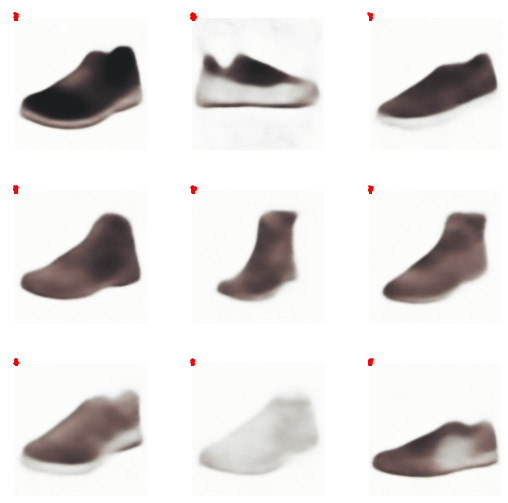

In [ ]:
#epochs = 5
base_lr = 1e-5# gmlr #/= 2
epochs = 200

#learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
#learn.fit_one_cycle(epochs, lr_max= 1e-3)
#learn.fit_flat_cos(epochs,lr=lr1,pct_start=.05)
learn.fit_flat_cos(epochs,lr=1e-4)
learn.show_results()

In [ ]:
prefix = f"BVae-{'TMP'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

### 64 latents, alpha=5

In [ ]:
latent_dim = 64
alpha = 5 # doubled because latent is half?
batchmean = True
useL1 = False


# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]


metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resnblock'
vae = ResBlockBVAE(get_resblockencoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,



(0.0005248074419796466,
 0.002511886414140463,
 0.0015183469280600549,
 0.001148153911344707)

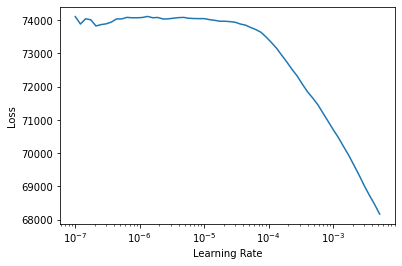

In [ ]:
# NOTE: lf_finder does NOT work correctly with our annealed kl_weight... 

lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#put in the annealied KL_weight...
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight': default_KL_anneal_in()} ) )

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,60796.062500,60585.625000,60517.253906,0.025750,0.098875,-4.970387,1320.856079,0.047932,65127.375000,0.377387,0.053540,1.088653,00:23
1,48086.773438,30546.251953,30129.642578,0.004717,0.025443,-7.855788,2214.793457,0.185387,45675.964844,0.253051,0.018211,1.366696,00:24
2,39698.820312,32652.861328,32009.542969,0.014292,0.053469,-6.127406,1660.816162,0.385156,45614.257812,0.241993,0.027114,1.017001,00:24
3,36479.828125,31992.818359,31128.556641,0.005917,0.074828,-5.353322,1415.799561,0.607671,45357.949219,0.253544,0.029845,0.808270,00:24
4,34833.515625,31738.466797,30794.025391,0.026434,0.109183,-4.546987,1163.327393,0.808860,45078.839844,0.272505,0.036400,0.685538,00:24
5,33806.316406,31220.535156,30251.041016,0.022280,0.138716,-4.065381,1017.731262,0.948876,44729.792969,0.304989,0.045479,0.685290,00:24
6,32890.265625,30814.718750,29903.451172,0.018232,0.168706,-3.698976,908.077454,0.999986,44455.097656,0.325861,0.060082,0.769017,00:24
7,32158.898438,31043.355469,30182.759766,0.021155,0.187295,-3.518874,856.945496,1.000000,44683.191406,0.343579,0.072742,0.848496,00:24
8,31607.242188,30939.902344,30098.326172,0.023286,0.197579,-3.443414,837.854004,1.000000,44652.160156,0.358087,0.082781,0.930757,00:24
9,31372.986328,31269.992188,30437.755859,0.023314,0.201297,-3.410339,828.747559,1.000000,44928.500000,0.361912,0.085013,0.941856,00:23


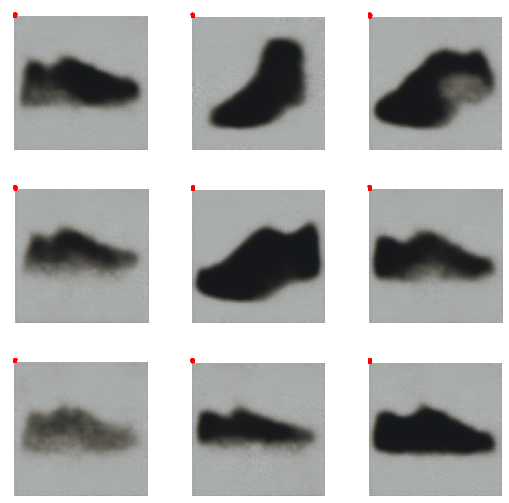

In [ ]:
#fit the backend of the VAE (n)
# the defaults are pretty good for now
n_epochs = 10

#learn.fit_one_cycle(freeze_epochs1,lr_max= lr1)#, lr_max= base_lr)
#learn.fit_flat_cos(n_epochs, lr=lr1, pct_start=0.5)
learn.fit_flat_cos(n_epochs, lr=1e-4,pct_start=0.5)

learn.show_results()


This initial "burning in" of the KLD regularization is very unstable...

In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

#learn.unfreeze()


(9.12010818865383e-08,
 0.00010964782268274575,
 5.486951188231615e-05,
 3.1622778351447778e-06)

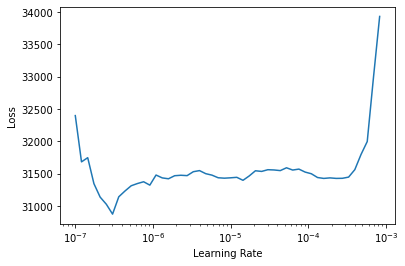

In [ ]:

lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#epochs = 5
base_lr = 1e-5# gmlr #/= 2
epochs = 200

#learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
#learn.fit_one_cycle(epochs, lr_max= 1e-3)
#learn.fit_flat_cos(epochs,lr=lr1,pct_start=.05)
learn.fit_flat_cos(epochs,lr=1e-4)
learn.show_results()

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,31183.568359,28540.281250,27787.994141,0.009710,0.228973,-3.132697,747.457214,1.000000,42970.894531,0.377200,0.089601,0.907798,00:23
1,30451.667969,27666.953125,26984.263672,0.028280,0.263691,-2.867905,678.904724,1.000000,42373.847656,0.414496,0.105721,0.962475,00:23
2,29676.958984,27919.148438,27293.328125,0.021193,0.299318,-2.657710,621.625000,1.000000,42480.113281,0.421737,0.129044,1.073113,00:24
3,28915.136719,26983.292969,26407.617188,0.017672,0.335278,-2.450533,571.424866,1.000000,41846.972656,0.447294,0.147862,1.127338,00:24
4,28107.253906,26539.660156,26004.732422,0.021271,0.371950,-2.281773,530.871826,1.000000,41445.335938,0.457745,0.168450,1.232203,00:24
5,27330.250000,25862.095703,25363.542969,0.017634,0.401382,-2.129037,494.978455,1.000000,40960.160156,0.472905,0.179359,1.237616,00:24
6,26611.375000,25196.773438,24726.632812,0.026015,0.430381,-2.000411,466.366180,1.000000,40400.945312,0.483834,0.190960,1.276329,00:24
7,25905.660156,24313.679688,23871.607422,0.027982,0.461414,-1.870677,438.386292,1.000000,39757.734375,0.493300,0.204275,1.304843,00:23
8,25256.289062,23759.125000,23335.220703,0.023450,0.485364,-1.785130,420.751678,1.000000,39342.785156,0.496424,0.215431,1.351444,00:24
9,24574.773438,22786.699219,22369.703125,0.025931,0.502921,-1.730989,413.373474,1.000000,38526.214844,0.505987,0.224725,1.396804,00:24


In [ ]:
prefix = f"BVae-{'TMP'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

### 64 latents, alpha=10

In [ ]:
latent_dim = 64
alpha = 10 # doubled because latent is half?
batchmean = True
useL1 = False


# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]


metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resnblock'
vae = ResBlockBVAE(get_resblockencoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,



In [ ]:
# NOTE: lf_finder does NOT work correctly with our annealed kl_weight... 

lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#put in the annealied KL_weight...
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight': default_KL_anneal_in()} ) )

In [ ]:
#fit the backend of the VAE (n)
# the defaults are pretty good for now
n_epochs = 10

#learn.fit_one_cycle(freeze_epochs1,lr_max= lr1)#, lr_max= base_lr)
#learn.fit_flat_cos(n_epochs, lr=lr1, pct_start=0.5)
learn.fit_flat_cos(n_epochs, lr=1e-4,pct_start=0.5)

learn.show_results()


This initial "burning in" of the KLD regularization is very unstable...

In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

#learn.unfreeze()


In [ ]:

lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#epochs = 5
base_lr = 1e-5# gmlr #/= 2
epochs = 200

#learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
#learn.fit_one_cycle(epochs, lr_max= 1e-3)
#learn.fit_flat_cos(epochs,lr=lr1,pct_start=.05)
learn.fit_flat_cos(epochs,lr=1e-4)
learn.show_results()

In [ ]:
prefix = f"BVae-{'TMP'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

## export / provenance

In [ ]:
#hide

from nbdev.export import notebook2script
notebook2script()


## CODE graveyard 

In [ ]:
# not using...
class LatentTuple(fastuple):
    "Basic type for tuple of tensor (vectors)"
    _show_args = dict(s=10, marker='.', c='r')
    @classmethod
    def create(cls, ts): 
        if isinstance(ts,tuple):
            mu,logvar = ts
        elif ts is None:
            mu,logvar = None,None
        else:
            mu = None
            logvar = None
            
        if mu is None: mu = torch.empty(0)
        elif not isinstance(mu, Tensor): Tensor(mu) 
        
        if logvar is None: logvar = torch.empty(0)
        elif not isinstance(logvar,Tensor): Tensor(logvar)
            
        return cls( (mu,logvar) ) 
        
    def show(self, ctx=None, **kwargs): 
        mu,logvar = self
        if not isinstance(mu, Tensor) or not isinstance(logvar,Tensor): return ctx

        title_str = f"mu-> {mu.mean():e}, {mu.std():e}  logvar->{logvar.mean():e}, {logvar.std():e}"
    
        if 'figsize' in kwargs: del kwargs['figsize']
        if 'title' in kwargs: kwargs['title']=title_str
        if ctx is None:
            _,axs = plt.subplots(1,2, figsize=(12,6))
            x=torch.linspace(0,1,mu[0].shape[0])
            axs[0].scatter(x, mu[:], **{**self._show_args, **kwargs})
            axs[1].scatter(x, logvar[:], **{**self._show_args, **kwargs})
            ctx = axs[1]
        
        ctx.scatter(mu[:], logvar[:], **{**self._show_args, **kwargs})
        return ctx
    
# could we do a typedispatch to manage the transforms...?
def VAETargetTupleBlock(): 
    return TransformBlock(type_tfms=VAETargetTuple.create, batch_tfms=IntToFloatTensor)

def LatentTupleBlock(): 
    return TransformBlock(type_tfms=LatentTuple.create, batch_tfms=noop)
    

# class TensorPoint(TensorBase):
#     "Basic type for points in an image"
#     _show_args = dict(s=10, marker='.', c='r')

#     @classmethod
#     def create(cls, t, img_size=None)->None:
#         "Convert an array or a list of points `t` to a `Tensor`"
#         return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

#     def show(self, ctx=None, **kwargs):
#         if 'figsize' in kwargs: del kwargs['figsize']
#         x = self.view(-1,2)
#         ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})
#         return ctx



In [ ]:
latent_dim = 128
dropout = .2
im_size = IMG_SIZE
n_blocks = 5        
nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
nfs.reverse()
# decoder = nn.Sequential(
#             nn.Linear(latent_size, 16),
#             UnFlatten(4),
#             ResBlock(1, 3, 4, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, 4, 8, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, 8, 16, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(16, 1, 3),
#             nn.Dropout2d(dropout),
#             #nn.AdaptiveAvgPool2d((3,im_size, im_size)) 
# )





n_blocks = 5
hidden_dim = 2048
out_range = [-1,1]
tst = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim), #nn.Linear(latent_dim, 16)
            nn.Linear(hidden_dim,im_size*n_blocks*n_blocks), #nn.Linear(latent_dim, 16)
            ResizeBatch(im_size,n_blocks,n_blocks),#UnFlatten(n_blocks), #4
            ResBlock(1, nfs[0], nfs[1], act_cls=Mish), #ResBlock(1, 1, 4, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[1], nfs[2], act_cls=Mish), #RResBlock(1, 4, 8, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[2], nfs[3], act_cls=Mish), #ResBlock(1, 8, 16, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[3], nfs[4], act_cls=Mish), #nn.Conv2d(16, 1, 3),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[4], nfs[5], act_cls=Mish), #nn.Conv2d(16, 1, 3),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[5], nfs[6], act_cls=Mish), #nn.Conv2d(16, 1, 3),
            #nn.Dropout2d(dropout),
            #nn.Upsample(scale_factor=2),            #
            #nn.AdaptiveAvgPool2d((3,im_size, im_size)),
            SigmoidRange(*out_range), #nn.Sigmoid()
)
tst,nfs

In [ ]:
inp=    torch.randn((32,latent_dim))
#last_size = model_sizes(tst ) #[-1][1]
#num_features_model(tst)
#last_size
#nfs
tst(inp).shape,nfs
#last_size

In [ ]:
z_dim = 100
enc = nn.Sequential(
    ResBlock(1, 1, 16, act_cls=nn.ReLU, norm_type=None),
    nn.MaxPool2d(2, 2),
    ResBlock(1, 16, 4, act_cls=nn.ReLU, norm_type=None),
    nn.MaxPool2d(2, 2),
    Flatten()
)
# torch.Size([32, 1, 28, 28])
# torch.Size([32, 16, 28, 28])
# torch.Size([32, 16, 14, 14])
# torch.Size([32, 4, 14, 14])
# torch.Size([32, 4, 7, 7])
# torch.Size([32, 196])

latent_size = 100

enc = nn.Sequential(
            ResBlock(1, 3, 5, stride=2, act_cls=Mish),#  1->3
            ResBlock(1, 5, 5, stride=2, act_cls=Mish),
            ResBlock(1, 5, 1, stride=2, act_cls=Mish),
            Flatten(),
            nn.Linear(400, latent_size) # 16->400
        )
#  torch.Size([32, 1, 28, 28])
# torch.Size([32, 5, 14, 14])
# torch.Size([32, 5, 7, 7])
# torch.Size([32, 1, 4, 4])
# torch.Size([32, 16])
# torch.Size([32, 4])       
inp=    torch.randn((32,3,160,160))
for ii in range(0,8):
    print(enc[:ii](inp).shape)

z = enc(inp)


In [ ]:
dropout=0
dec = nn.Sequential(
            nn.Linear(latent_size, 16),
            UnFlatten(4),
            ResBlock(1, 1, 4, act_cls=Mish), #4->5
            #nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 4, 8, act_cls=Mish),
            #nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 8, 16, act_cls=Mish),
            #nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 3, 3), #1->3
            #nn.Dropout2d(dropout),
            nn.AdaptiveAvgPool2d((28, 28)),
            nn.Sigmoid()
        )

# torch.Size([32, 4])
# torch.Size([32, 16])
# torch.Size([32, 1, 4, 4])
# torch.Size([32, 4, 4, 4])
# torch.Size([32, 4, 8, 8])
# torch.Size([32, 8, 8, 8])
# torch.Size([32, 8, 16, 16])
# torch.Size([32, 16, 16, 16])
# torch.Size([32, 16, 32, 32])
# torch.Size([32, 1, 30, 30])
# torch.Size([32, 1, 28, 28])


for ii in range(0,12):
    print(dec[:ii](z).shape)

In [ ]:
n_blocks = 5
BASE = im_size//2**5        
nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
n = len(nfs)
hidden_dim = 2048

BASE = im_size//2**5
        # encoder
in_dim = nfs[-1] * BASE**2 
        
modules =  [ResBlock(1, nfs[i],nfs[i+1], 
                          stride=2, act_cls=Mish)  for i in range(n - 1)]    
# enc =  nn.Sequential(
#                 ConvLayer(nfs[0],nfs[1],ks=5,stride=2,padding=2),
#                 ConvLayer(nfs[1],nfs[2],ks=5,stride=2,padding=2),
#                 ConvLayer(nfs[2],nfs[3],ks=5,stride=2,padding=2),
#                 ConvLayer(nfs[3],nfs[4],ks=5,stride=2,padding=2),
#                 ConvLayer(nfs[4],nfs[5],ks=5,stride=2,padding=2),
#                 Flatten(),
#                 LinBnDrop(in_dim,hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
#             )

enc =  nn.Sequential(*modules,
                Flatten(),
                LinBnDrop(in_dim,hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
            )

nfs.reverse()

print(nfs)
#last_size = model_sizes(enc, size=(28,28))[-1][1]



    
encoder = nn.Sequential(enc, nn.Linear(hidden_dim, z_dim))
        
decoder = nn.Sequential(
            nn.Linear(z_dim, im_size*n_blocks*n_blocks),
            ResizeBatch(im_size,n_blocks,n_blocks),#UnFlatten(n_blocks), #4
            ResBlock(1, nfs[0], nfs[1], ks=1, act_cls=nn.ReLU, norm_type=None),
            #nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[1], nfs[2], act_cls=nn.ReLU, norm_type=None),
            #nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(nfs[2], 3, 3, padding=1),
            #nn.Dropout2d(dropout),
            nn.Sigmoid()
        )
#last_size

#             nn.Linear(latent_dim,hidden_dim), #nn.Linear(latent_dim, 16)
#             nn.Linear(hidden_dim,im_size*n_blocks*n_blocks), #nn.Linear(latent_dim, 16)
#             ResizeBatch(im_size,n_blocks,n_blocks),#UnFlatten(n_blocks), #4
#             ResBlock(1, nfs[0], nfs[1], act_cls=Mish), #ResBlock(1, 1, 4, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, nfs[1], nfs[2], act_cls=Mish), #RResBlock(1, 4, 8, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, nfs[2], nfs[3], act_cls=Mish), #ResBlock(1, 8, 16, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, nfs[3], nfs[4], act_cls=Mish), #nn.Conv2d(16, 1, 3),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, nfs[4], nfs[5], act_cls=Mish), #nn.Conv2d(16, 1, 3),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, nfs[5], nfs[6], act_cls=Mish), #nn.Conv2d(16, 1, 3),

            

inp=    torch.randn((32,3,160,160))

#encoder[:1](inp).shape
for ii in range(0,10):
    print(enc[:ii](inp).shape)

z = encoder(inp)
for ii in range(0,14):
    print(decoder[:ii](z).shape)


In [ ]:
class UnFlatten(Module):
    def __init__(self, size=7):
        self.size = size
    def forward(self, input):
        return input.view(input.size(0), -1, self.size, self.size)

class MMD_VAE(Module):
    def __init__(self, latent_size):        
        self.encoder = nn.Sequential(
            ResBlock(1, 1, 5, stride=2, act_cls=Mish),
            ResBlock(1, 5, 5, stride=2, act_cls=Mish),
            ResBlock(1, 5, 1, stride=2, act_cls=Mish),
            Flatten(),
            nn.Linear(16, latent_size)
        )
        
        dropout=0
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 16),
            UnFlatten(4),
            ResBlock(1, 1, 4, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 4, 8, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 8, 16, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 1, 3),
            nn.Dropout2d(dropout),
            nn.AdaptiveAvgPool2d((28, 28)),
            nn.Sigmoid()
        )
        
    
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent), latent


In [ ]:

    
#decoder
n_blocks = 5        
nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
nfs.reverse()
n = len(nfs)


tst = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim, #nn.Linear(latent_dim, 16)
            nn.Linear(hidden_dim,im_size*n_blocks*n_blocks) #nn.Linear(latent_dim, 16)
            UnFlatten(n_blocks), #4
            ResBlock(1, nfs[0], nfs[1], act_cls=Mish), #ResBlock(1, 1, 4, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[1], nfs[2], act_cls=Mish), #RResBlock(1, 4, 8, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[2], nfs[3], act_cls=Mish), #ResBlock(1, 8, 16, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[3], nfs[4], act_cls=Mish), #nn.Conv2d(16, 1, 3),
            nn.Dropout2d(dropout),
            nn.AdaptiveAvgPool2d((3,im_size, im_size)),
            SigmoidRange(*out_range)#nn.Sigmoid()

    
                                         *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
    

In [ ]:
# hide



class AE_vanillaResNet(Module):
    def __init__(self,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE,pretrained=True):
        #  drop_p=0.0 default turns off dropout
        
        
        self.im_size=im_size
        # encoder

          
        n_blocks = 5
        BASE = IMG_SIZE//2**5
        
        
        nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
        n = len(nfs)

        modules =  [ResBlock(1,nfs[i],nfs[i+1],
                                ks=5,stride=2,padding=2) for i in range(n - 1)]       
        #self.in_dim = nfs[-1]*BASE*BASE# Sampling vector
        self.in_dim = nfs[-1]*(BASE)**2# Sampling vector

        self.latent_dim = latent_dim
        self.hidden_dim = 2048
        self.encoder = nn.Sequential(*modules,
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )
        

        self.bn = nn.Linear(self.hidden_dim,self.latent_dim)
        #self.bn = AEBottleneck(self.hidden_dim,self.latent_dim)     

        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleResBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        return self.decoder(z)
    
    def encode(self, x):
        h = self.encoder(x)
        return self.bn(h)
            
    def forward(self, x):
        """
        pass the "latents" out to keep the learn mechanics consistent... 
        """
        h = self.encoder(x)
        z = self.bn(h)
        x_reconst = self.decoder(z)                    
        dummy_std = torch.ones_like(h) * h.std(dim=1)
        latents = torch.stack([h,torch.exp(0.5 * dummy_std)] ,dim=-1)


        return x_reconst , latents
    

    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 10
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 40
#learn.unfreeze()
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e6, pct_start=0.05)

#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"frozen{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

In [ ]:
##. resblock VAE

In [ ]:
x=1
x

In [ ]:
# hide
    
# check enc_dim... 
class CVAE_vanilla(Module):
    def __init__(self,latent_dim=128, hidden_dim=2048, im_size=IMG_SIZE,out_range=OUT_RANGE,pretrained=True):
        #  drop_p=0.0 default turns off dropout, removed enc_dim=512
        
        self.im_size=im_size
        # encoder

          
        n_blocks = 5
        BASE = im_size//2**5
        
        
        nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
        n = len(nfs)

        modules =  [ConvLayer(nfs[i],nfs[i+1],
                                ks=5,stride=2,padding=2) for i in range(n - 1)]       
        #self.in_dim = nfs[-1]*BASE*BASE# Sampling vector
        self.in_dim = nfs[-1]*(BASE)**2# Sampling vector

        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(*modules,
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )
        

        self.bn = VAELayer(self.hidden_dim,self.latent_dim)     

        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,self.hidden_dim,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                     LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        z = self.decoder(z)
        return z
    
    def reparam(self, h):
        return self.bn(h)

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.reparam(h)
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_hat = self.decode(z)
        latents = torch.stack([mu,logvar],dim=-1)
        return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]
    
    

    
    

In [ ]:
#hide

# this is the pre-  refactored working version
class VAE_rnet(Module):
    def __init__(self,enc_dim=512, hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
        #  drop_p=0.0 default turns off dropout
        
        self.im_size=im_size
        BASE = im_size//2**5
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        # encoder
        arch,cut = resnet18(pretrained=True),-4
        self.in_dim = enc_dim * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800
        
        self.encoder = nn.Sequential(*list(arch.children())[:cut],
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )



        # VAE Bottleneck
        self.bn = VAELayer(self.hidden_dim,self.latent_dim)     

        #decoder
        n_blocks = 5        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,self.hidden_dim,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                     LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        z = self.decoder(z)
        return z
    
    def reparam(self, h):
        return self.bn(h)

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.reparam(h)
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_hat = self.decode(z)
        latents = torch.stack([mu,logvar],dim=-1)
        return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]
    
resnet_vae = VAE_rnet(enc_dim=512)
x_hat,latents = resnet_vae.cuda()(x)

In [ ]:
## ARCHITECUTE
def create_encoder(nfs,ks,conv=nn.Conv2d,bn=nn.BatchNorm2d,act_fn = nn.ReLU):
    """
    constructor for generic convolutional encoder 
    """
    n = len(nfs)
    conv_layers = [nn.Sequential(ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i],
                                            conv = conv,bn=bn,act_fn=act_fn, padding = ks[i] //2 ),
                                 Downsample(channels=nfs[i+1],filt_size=3,stride=2))
                                   for i in range(n-1)]        
    convs = nn.Sequential(*conv_layers)
    return convs

def create_encoder_denseblock(n_dense,c_start):
    """
    constructor for resnet with dense blocks  (?) 

    n_dense": 3,
    "c_start": 4
    """
    first_layer = nn.Sequential(ConvBnRelu(3,c_start,kernel_size=3,padding = 1),
                                ResBlock(c_start),
                                Downsample(channels=4,filt_size=3,stride=2))
    
    layers = [first_layer] + [
        nn.Sequential(
            DenseBlock(c_start * (2**c)),
            Downsample(channels=c_start * (2**(c+1)),filt_size=3,stride=2)) for c in range(n_dense)
    ]
    
    model = nn.Sequential(*layers)
    
    return model

def create_decoder(nfs, ks, size, conv=nn.Conv2d, bn=nn.BatchNorm2d, act_fn=nn.ReLU):
    """
    CURR VALUES:
    "nfs":[66,3*32,3*16,3*8,3*4,3*2,3,1,3],
    "ks": [ 3, 1, 3,1,3,1,3,1],   
    "size": IMG_SIZE 
    """
    n = len(nfs)
    
    # We add two channels to the first layer to include x and y channels
    first_layer = ConvBnRelu(nfs[0], #input size 
                             nfs[1], # output size
                             conv = PointwiseConv,
                             bn=bn,
                             act_fn=act_fn)

    conv_layers = [first_layer] + [ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i-1],
                                              padding = ks[i-1] // 2,conv = conv,bn=bn,act_fn=act_fn)
                                   for i in range(1,n - 1)]        
    dec_convs = nn.Sequential(*conv_layers)
    
    dec = nn.Sequential(SpatialDecoder2D(size),dec_convs)
    #SigmoidRange(*y_range)
    return dec

def decoder_simple(y_range=OUT_RANGE, n_out=3):
    return nn.Sequential(#UpsampleBlock(64),
                         UpsampleBlock(32),
                         nn.Conv2d(16, n_out, 1),
                         SigmoidRange(*y_range)
                        )